## Titanic survival

Neste notebook iremos analisar os dados do dataset Titanic para criar um modelo preditivo dos sobreviventes a partir de informações sobre os passageiros.  
O dataset utilizado pode ser conferido e baixado diretamente do Kaggle:
https://www.kaggle.com/c/titanic/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
df = pd.read_csv('titanic_data.csv', skipinitialspace = True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Definindo as variáveis de input e a variável target
X = df.drop(['PassengerId', 'Name', 'Survived', 'Ticket', 'Cabin'], axis = 1)
Y = df[['Survived']]

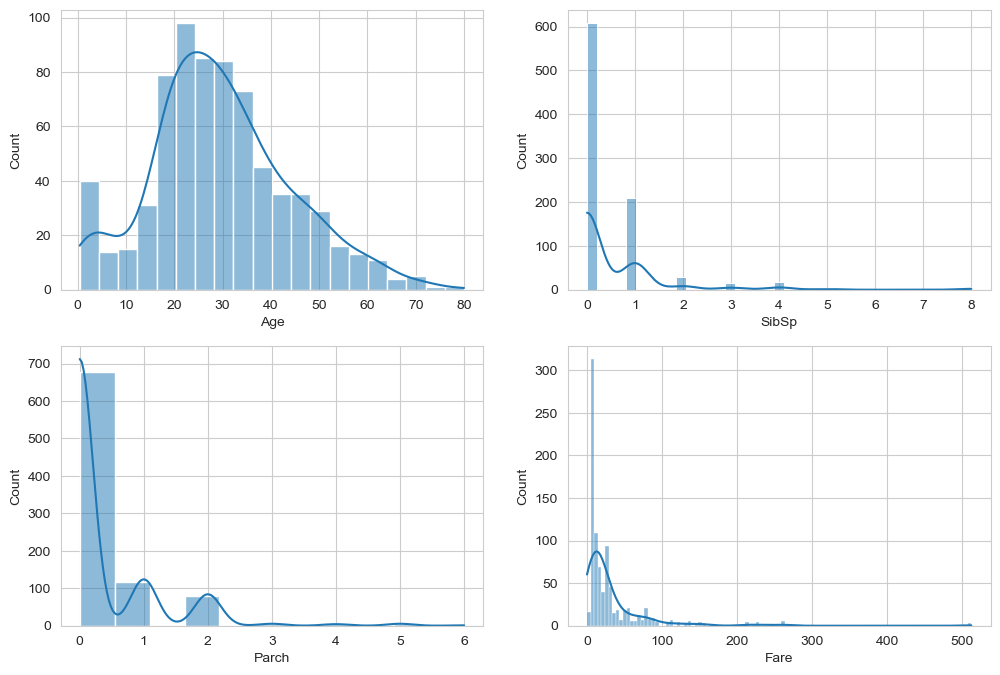

In [6]:
# Visualizando a distribuição dos dados
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sns.histplot(data = X['Age'], kde = True, ax = axes[0, 0])
sns.histplot(data = X['SibSp'], kde = True, ax = axes[0, 1])
sns.histplot(data = X['Parch'], kde = True, ax = axes[1, 0])
sns.histplot(data = X['Fare'], kde = True, ax = axes[1, 1])
plt.show()

In [7]:
# Realizando o split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 25)

In [8]:
# Verificando como as variáveis de teste e treino ficaram distribuídas
print("Original True : {0} ({1:0.2f}%)".format(len(df.loc[df['Survived'] == 1]), 
                                               (len(df.loc[df['Survived'] == 1])/len(df.index) * 100)))

print("Original False : {0} ({1:0.2f}%)".format(len(df.loc[df['Survived'] == 0]), 
                                               (len(df.loc[df['Survived'] == 0])/len(df.index) * 100)))
print("")
print("Training True : {0} ({1:0.2f}%)".format(len(Y_train[Y_train['Survived'] == 1]), 
                                               (len(Y_train[Y_train['Survived'] == 1])/len(Y_train) * 100)))

print("Training False : {0} ({1:0.2f}%)".format(len(Y_train[Y_train['Survived'] == 0]), 
                                               (len(Y_train[Y_train['Survived'] == 0])/len(Y_train) * 100)))
print("")
print("Test True : {0} ({1:0.2f}%)".format(len(Y_test[Y_test['Survived'] == 1]), 
                                               (len(Y_test[Y_test['Survived'] == 1])/len(Y_test) * 100)))

print("Test False : {0} ({1:0.2f}%)".format(len(Y_test[Y_test['Survived'] == 0]), 
                                               (len(Y_test[Y_test['Survived'] == 0])/len(Y_test) * 100)))

Original True : 342 (38.38%)
Original False : 549 (61.62%)

Training True : 239 (38.36%)
Training False : 384 (61.64%)

Test True : 103 (38.43%)
Test False : 165 (61.57%)


In [9]:
# Pipeline para tratar dados NaN e normalização
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')), # Como podemos observar, as distribuições não são gaussianas, logo, aplicamos a mediana
#     ('scaler', StandardScaler())
    ('scaler', PowerTransformer()) # Algoritmos baseados em árvore de decisão não precisam de transformação de dados, mas aplicamos aqui para tsetar o SVM
])

# Pipeline para transformação de dados categóricos
cat_transformer = Pipeline(steps = [
    ('one-hot-encoder', OneHotEncoder())
])

# Compondo o pré-processamento dos dados
def preprocessor(numCol, catCol):
    preprocessing = ColumnTransformer(transformers = [
        ('num', num_transformer, numCol),
        ('cat', cat_transformer, catCol)
    ])
    return preprocessing

In [10]:
# Criando o modelo
preprocessing = preprocessor(['Age', 'SibSp', 'Parch', 'Fare'], ['Pclass', 'Sex', 'Embarked'])

model = Pipeline(steps = [
    ('preprocessing', preprocessing),
    ('randomforest', RandomForestClassifier(max_depth = 4, random_state = 42))
])

In [11]:
# Treinando o modelo
model.fit(X_train, Y_train.values.ravel())
train_score = model.score(X_train, Y_train.values.ravel())

In [12]:
# Testando o modelo
test_score = model.score(X_test, Y_test.values.ravel())
predict_test = model.predict(X_test)

In [13]:
# Verificando o score
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_test, predict_test)))

Exatidão (Accuracy): 0.7985


In [14]:
def saveSubmission(df_test, ml_model, X_ftest):
    submission = pd.DataFrame()
    submission['PassengerId'] = df_test['PassengerId']
    submission['Survived'] = ml_model.predict(X_ftest)
    
    submission.to_csv('submission.csv', index = False)
    return submission

In [15]:
test_file = 'test.csv'
df_test = pd.read_csv(test_file)

In [16]:
# Fazendo predição com o modelo criado e salvando os resultados
X_rftest = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
submission_rf = saveSubmission(df_test, model, X_rftest)

Utilizando o dataset de teste e enviando o resultado ao Kaggle, podemos ver que a acurária do modelo inicial é de 0.77511
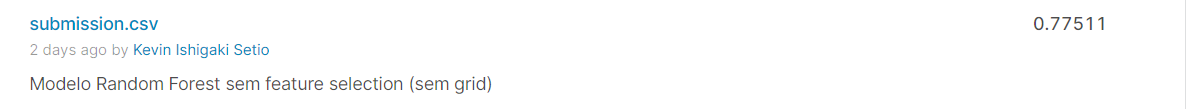

In [17]:
# Realizando o tuning dos parâmetros
params = {'randomforest__n_estimators': [50, 100, 150, 200],
          'randomforest__criterion': ['gini', 'entropy'],
          'randomforest__max_depth': [3, 4, 5, 6, 7],
          'randomforest__max_features': ['auto', 'log2']}

gs_frc1 = GridSearchCV(model,
                     param_grid = params,
                     scoring = 'accuracy',
                     cv = 5)

gs_frc1.fit(X, Y.values.ravel())
gs_frc1.best_params_

{'randomforest__criterion': 'gini',
 'randomforest__max_depth': 7,
 'randomforest__max_features': 'auto',
 'randomforest__n_estimators': 200}

In [18]:
# Fazendo predição com o modelo após o tuning dos parâmmetros e salvando os resultados
Xtune_rftest = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
submission_rf = saveSubmission(df_test, gs_frc1, Xtune_rftest)

In [19]:
# Testando o modelo com o SVM
model_svc = Pipeline(steps = [
    ('preprocessing', preprocessing),
    ('svm', svm.SVC())
])

In [20]:
# Treinando o modelo
model_svc.fit(X_train, Y_train.values.ravel())
train_score_svc = model_svc.score(X_train, Y_train.values.ravel())

In [21]:
# Testando o modelo
test_score_svc = model_svc.score(X_test, Y_test.values.ravel())
predict_test_svc = model_svc.predict(X_test)

In [22]:
# Verificando o score
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(Y_test, predict_test_svc)))

Exatidão (Accuracy): 0.7985


In [23]:
# Fazendo predição com o modelo criado e salvando os resultados
X_svctest = df_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
submission_svc = saveSubmission(df_test, model_svc, X_svctest)

Fazendo o tuning dos parâmetros e enviando novamente o resultado ao Kaggle, podemos ver que agora o modelo apresentou um melhor desempenho em relação ao modelo inicial
![Random_forest_grid](Rf1_grid.PNG)

In [24]:
# Preparando os dados para aplicar o teste chi2 a fim verificar as features mais relevantes para o modelo
sex_map = {'male': 0, 'female': 1}
embarked_map = {'C': 0, 'S': 1, 'Q': 2}

X_est = df.copy()
X_est['Sex'] = X_est['Sex'].map(sex_map)
X_est['Embarked'] = X_est['Embarked'].map(embarked_map)
X_est = X_est.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
X_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


In [25]:
# Retirando as linhas com valores NaN para aplicarmos o método de análise estatística
X_est = X_est.dropna()
Y_est = X_est['Survived']
X_est = X_est.drop(['Survived'], axis = 1)
X_est.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int64  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 44.5 KB


In [26]:
Y_est = Y_est.reset_index(drop = True)
Y_est

0      0
1      1
2      1
3      1
4      0
      ..
707    0
708    0
709    1
710    1
711    0
Name: Survived, Length: 712, dtype: int64

In [27]:
# Aplicando teste chi2 para verificar as melhores features para o modelo
sel_feat = SelectKBest(score_func = chi2, k = 4).fit(X_est, Y_est)
print(sel_feat.scores_)
sel_bool = sel_feat.get_support()
# print(sel_bool)
# features = fit.transform(X_est)
# print(features[0:5,:])

[2.82432132e+01 1.30515207e+02 3.42460978e+01 2.88690988e-01
 1.08834998e+01 4.08167942e+03 6.02004416e+00]


In [28]:
# Criando as novas variáveis de treino e teste
X_train2 = X_train[X_train.columns[sel_bool]]
X_test2 = X_test[X_test.columns[sel_bool]]

In [29]:
preprocessing2 = preprocessor(['Age', 'Fare'], ['Pclass', 'Sex'])

model2 = Pipeline(steps = [
    ('preprocessing', preprocessing2),
    ('randomforest', RandomForestClassifier(max_depth = 4, random_state = 42))
])

In [30]:
# Treinando o modelo
model2.fit(X_train2, Y_train.values.ravel())
train_score2 = model2.score(X_train2, Y_train.values.ravel())

In [31]:
# Testando o modelo
test_score2 = model2.score(X_test2, Y_test.values.ravel())
predict_test2 = model2.predict(X_test2)

In [32]:
# Exibindo o score do novo modelo
print(f"Exatidão (Accuracy): {test_score2:0.4f}")

Exatidão (Accuracy): 0.8060


Utilizando o modelo original, mas dessa vez realizando a 'feature selection', podemos ver que o resultado não sofreu alterações em relação ao modelo inicial
![Random_Forest_feature_selection](Rf_feat.PNG)

In [33]:
# Fazendo predição com o novo modelo criado e salvando os resultados
Xfeat_rftest = df_test[['Pclass', 'Sex', 'Age', 'Fare']]
submission_rf2 = saveSubmission(df_test, model2, Xfeat_rftest)

In [34]:
# Realizando o tuning dos parâmetros
params = {'randomforest__n_estimators': [50, 100, 150, 200],
          'randomforest__criterion': ['gini', 'entropy'],
          'randomforest__max_depth': [3, 4, 5, 6, 7],
          'randomforest__max_features': ['auto', 'log2']}

gs_frc2 = GridSearchCV(model2,
                     param_grid = params,
                     scoring = 'accuracy',
                     cv = 5)

X_feat = X[X.columns[sel_bool]]
Y_feat = Y['Survived']

gs_frc2.fit(X_feat, Y_feat)
gs_frc2.best_params_

{'randomforest__criterion': 'gini',
 'randomforest__max_depth': 7,
 'randomforest__max_features': 'auto',
 'randomforest__n_estimators': 150}

In [35]:
gs_frc2.score(X_feat, Y_feat)

0.8956228956228957

In [36]:
# Fazendo predição com o modelo após o tuning dos parâmmetros e salvando os resultados
Xtune_rftest2 = df_test[['Pclass', 'Sex', 'Age', 'Fare']]
submission_rf2 = saveSubmission(df_test, gs_frc2, Xtune_rftest2)

Fazendo o tuning dos parâmetros do modelo com 'feature selection' e enviando novamente o resultado ao Kaggle, podemos ver que agora o modelo piorou o desempenho em relação aos modelos anteriores. 
Desta forma, pode-se concluir que realizar o tuning dos parâmetros causou um overfitting do modelo
![Random_forest_feature_grid](Rf_feat_grid.PNG)

In [37]:
model_svc2 = Pipeline(steps = [
    ('preprocessing', preprocessing2),
    ('svm', svm.SVC())
])

In [38]:
# Treinando o modelo
model_svc2.fit(X_train2, Y_train.values.ravel())
train_score_svc2 = model_svc2.score(X_train2, Y_train.values.ravel())

In [39]:
# Testando o modelo
test_score_svc2 = model_svc2.score(X_test2, Y_test.values.ravel())
predict_test_svc2 = model_svc2.predict(X_test2)

In [40]:
# Exibindo o score do novo modelo
print(f"Exatidão (Accuracy): {test_score_svc2:0.4f}")

Exatidão (Accuracy): 0.8060


In [41]:
# Fazendo predição com o novo modelo criado e salvando os resultados
Xfeat_svctest = df_test[['Pclass', 'Sex', 'Age', 'Fare']]
submission_svc2 = saveSubmission(df_test, model_svc2, Xfeat_svctest)

In [42]:
# filename = 'model_titanic.sav'
# pickle.dump(gs_frc.best_estimator, open(filename, 'wb'))